# Prepare data

In [91]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from ament_index_python.packages import get_package_share_directory


# Define the file path
oscillations_file = os.path.join(
    get_package_share_directory("furuta_pendulum_model"),
    "data",
    "simulation_sin_response_01.csv",
)


# Define the target columns for X and Y data
x_columns = [
    "/effort_control_sim/data.0",
    "/joint_states_sim/joint0/position",
    "/joint_states_sim/joint0/velocity",
    "/joint_states_sim/joint1/position",
    "/joint_states_sim/joint1/velocity",
]
y_columns = [
    "/joint_states_sim/joint0/position",
    "/joint_states_sim/joint0/velocity",
    "/joint_states_sim/joint1/position",
    "/joint_states_sim/joint1/velocity",
]
y_labels = [
    "velocity",
    "acceleration",
    "velocity",
    "acceleration",
]

# Define the starting index
starting_idx = 3150

In [92]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, x_columns, y_columns, starting_idx):
        self.time_col = "/joint_states_sim/header/stamp"
        self.x_columns = x_columns
        self.y_columns = y_columns

        # Read only the necessary columns
        self.data = pd.read_csv(
            csv_file,
            skiprows=range(1, starting_idx),
            usecols=self.x_columns + [self.time_col],
        )  

        # Modify and preprocess data
        self.modify_data()
        self.remove_nan()
        # self.normalize_data()

    def __len__(self):
        return len(self.data) - 1  # Exclude the last element

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        next_sample = self.data.iloc[idx + 1]

        x_data = torch.tensor(sample[self.x_columns], dtype=torch.float32)

        # Extract Y data (derivative)
        dt = next_sample[self.time_col] - sample[self.time_col]
        y_derivative = torch.tensor(
            [(next_sample[col] - sample[col]) / dt for col in self.y_columns],
            dtype=torch.float32,
        )

        return x_data, y_derivative

    def modify_data(self):
        last_value = 0.0
        for idx, row in self.data.iterrows():
            if np.isnan(row["/effort_control_sim/data.0"]):
                row["/effort_control_sim/data.0"] = last_value
            else:
                last_value = row["/effort_control_sim/data.0"]

    def remove_nan(self):
        self.data.dropna(inplace=True)

    def normalize_data(self):
        # Z-score normalization
        self.data[self.x_columns] = (
            self.data[self.x_columns] - self.data[self.x_columns].mean()
        ) / self.data[self.x_columns].std()



# Create the custom dataset
dataset = CustomDataset(oscillations_file, x_columns, y_columns, starting_idx)

In [93]:
for i in [0, int(len(dataset)/10), int(len(dataset)/2)]:
    x_data, y_data = dataset[i]
    print(x_data)

tensor([0., 0., 0., -0., -0.])
tensor([ 0.0226,  8.5107, 22.0000, -0.5041,  3.6296])
tensor([ -0.1973,   9.7214, -22.0000, -52.5355, -18.0549])


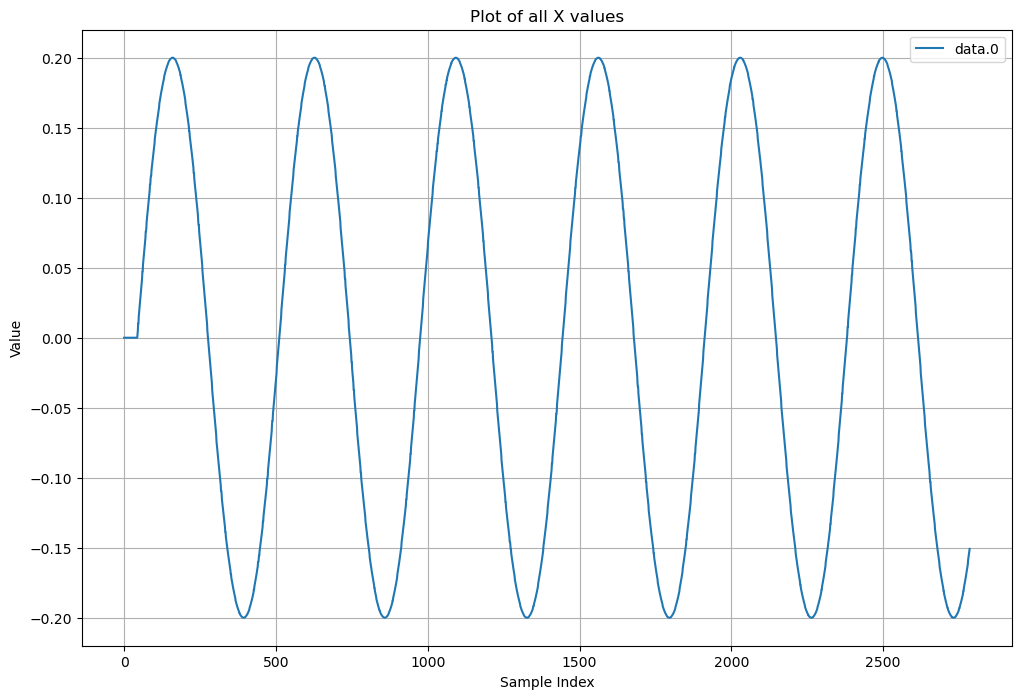

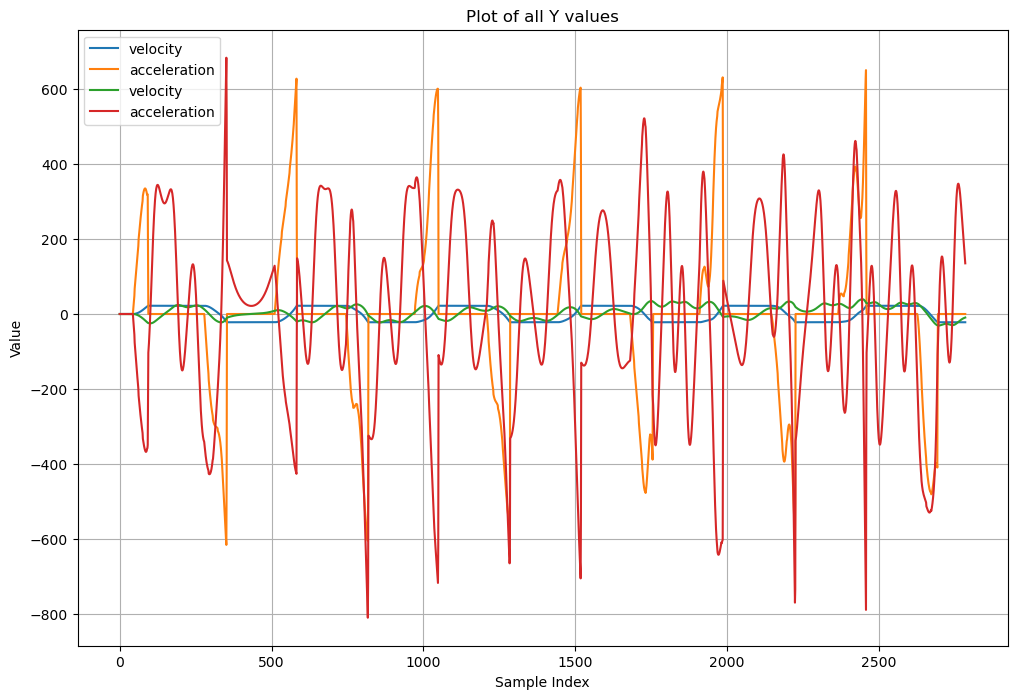

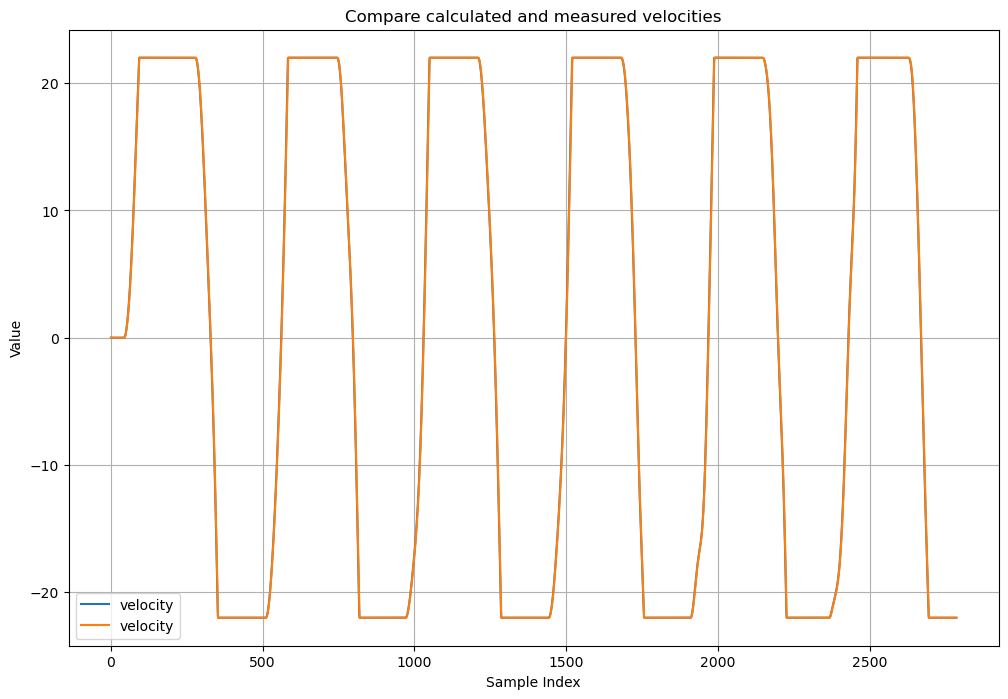

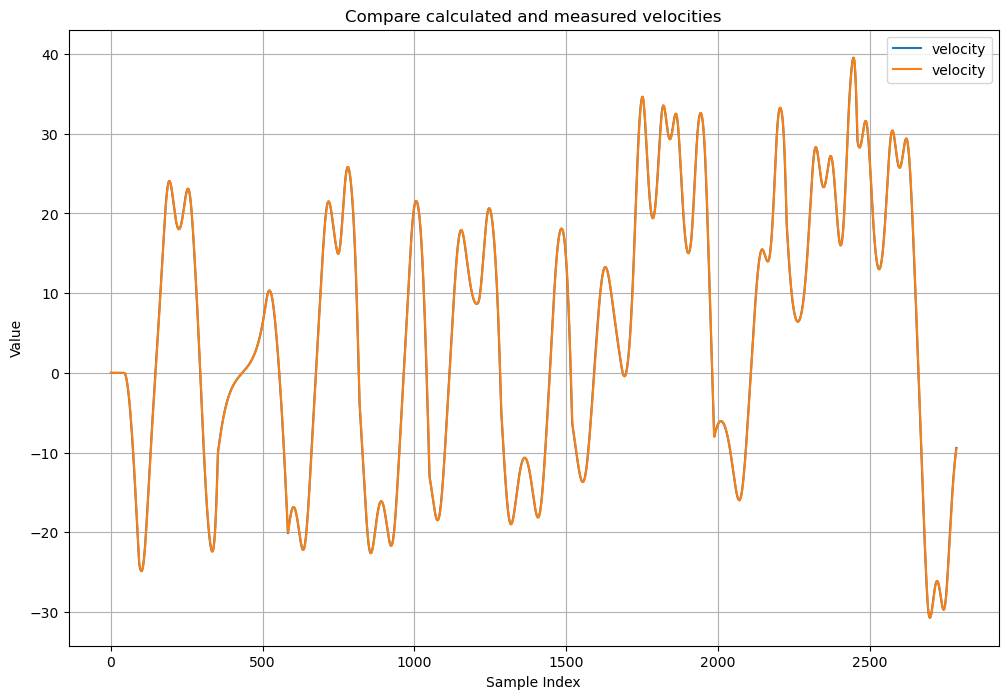

In [94]:
# Create vectors of X and Y values
all_x_values = []
all_y_values = []
for i in range(int(len(dataset) / 6)):
    x_data, y_data = dataset[i]
    all_x_values.append(x_data.numpy())
    all_y_values.append(y_data.numpy())

# Plot all X values
plt.figure(figsize=(12, 8))

for i in range(1):
    plt.plot([x[i] for x in all_x_values], label=x_columns[i].split("/")[-1])

plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Plot of all X values")
plt.legend()
plt.grid(True)
plt.show()

# Plot all Y values
plt.figure(figsize=(12, 8))

for i in range(len(y_columns)):
    plt.plot([y[i] for y in all_y_values], label=y_labels[i].split("/")[-1])

plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Plot of all Y values")
plt.legend()
plt.grid(True)
plt.show()

# Plot all Y values
plt.figure(figsize=(12, 8))

i = 0
plt.plot([y[i] for y in all_y_values], label=y_labels[i].split("/")[-1])
plt.plot([x[i + 2] for x in all_x_values], label=x_columns[i + 2].split("/")[-1])

plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Compare calculated and measured velocities")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))

i = 2
plt.plot([y[i] for y in all_y_values], label=y_labels[i].split("/")[-1])
plt.plot([x[i + 2] for x in all_x_values], label=x_columns[i + 2].split("/")[-1])

plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Compare calculated and measured velocities")
plt.legend()
plt.grid(True)
plt.show()

# Training neural net

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming your dataset is already defined
if torch.cuda.is_available():
    dataset = [(inputs.to(device), targets.to(device)) for inputs, targets in dataset]

class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)  # Increase the size of the first hidden layer
        self.fc2 = nn.Linear(512, 512)         # Add another hidden layer
        self.fc3 = nn.Linear(512, 512)         # Add another hidden layer
        self.fc4 = nn.Linear(512, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

# Define the input and output sizes
input_size = len(dataset[0][0])
output_size = len(dataset[0][1])

# Create the neural network
model = SimpleNN(input_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Define the data loader
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# TensorBoard writer
writer = SummaryWriter()

# Train the neural network
num_epochs = 1000
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss}")

    # Write loss to TensorBoard
    writer.add_scalar('Loss/train', running_loss, epoch)

print("Finished Training")

# Close TensorBoard writer
writer.close()

Epoch 1, Loss: 4867194.791015625
Epoch 2, Loss: 4383923.001953125
Epoch 3, Loss: 4017091.1030273438
Epoch 4, Loss: 3772773.5141601562
Epoch 5, Loss: 3604385.458984375
Epoch 6, Loss: 3476573.4658203125
Epoch 7, Loss: 3306573.6513671875
Epoch 8, Loss: 3114306.8920898438
Epoch 9, Loss: 2940217.1123046875
Epoch 10, Loss: 2788860.3095703125
Epoch 11, Loss: 2608479.2705078125
Epoch 12, Loss: 2484612.3310546875
Epoch 13, Loss: 2329320.221923828
Epoch 14, Loss: 2223128.0737304688
Epoch 15, Loss: 2112234.302001953
Epoch 16, Loss: 1992496.9389648438
Epoch 17, Loss: 1913861.0104980469
Epoch 18, Loss: 1809667.380859375
Epoch 19, Loss: 1709062.8447265625
Epoch 20, Loss: 1659019.2136230469
Epoch 21, Loss: 1570760.9282226562
Epoch 22, Loss: 1499536.96484375
Epoch 23, Loss: 1458338.3266601562
Epoch 24, Loss: 1362333.6088867188
Epoch 25, Loss: 1347195.2260742188
Epoch 26, Loss: 1272425.5014648438
Epoch 27, Loss: 1212388.9956054688
Epoch 28, Loss: 1161693.6142578125
Epoch 29, Loss: 1119713.2182617188
Ep

In [96]:

import torch
from torchdiffeq import odeint
import matplotlib.pyplot as plt

def f(t, x):
    with torch.no_grad():  # Ensure no gradient tracking
        x[0] = dataset[int(t*500)][0][0]
        return torch.cat((torch.tensor([dataset[int(t*500)][0][0]]).to(device), model(x))).to(device)

# Initial condition
x0 = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0]).to(device)

# Time points
t = torch.linspace(0, 1, 500).to(device)

# Integrate using odeint
out = odeint(f, x0, t)

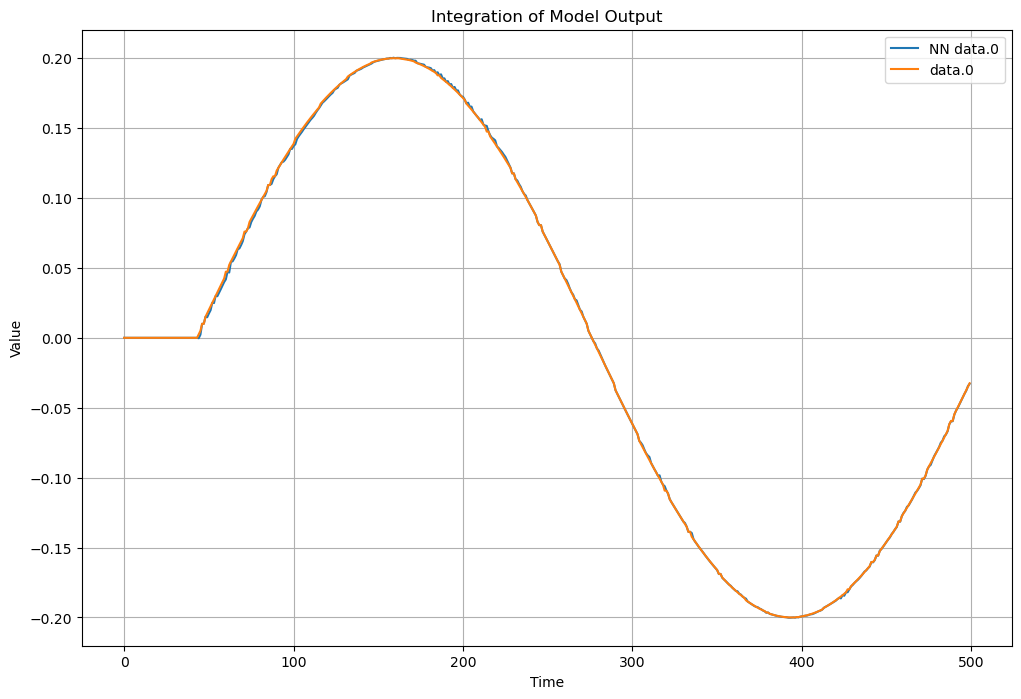

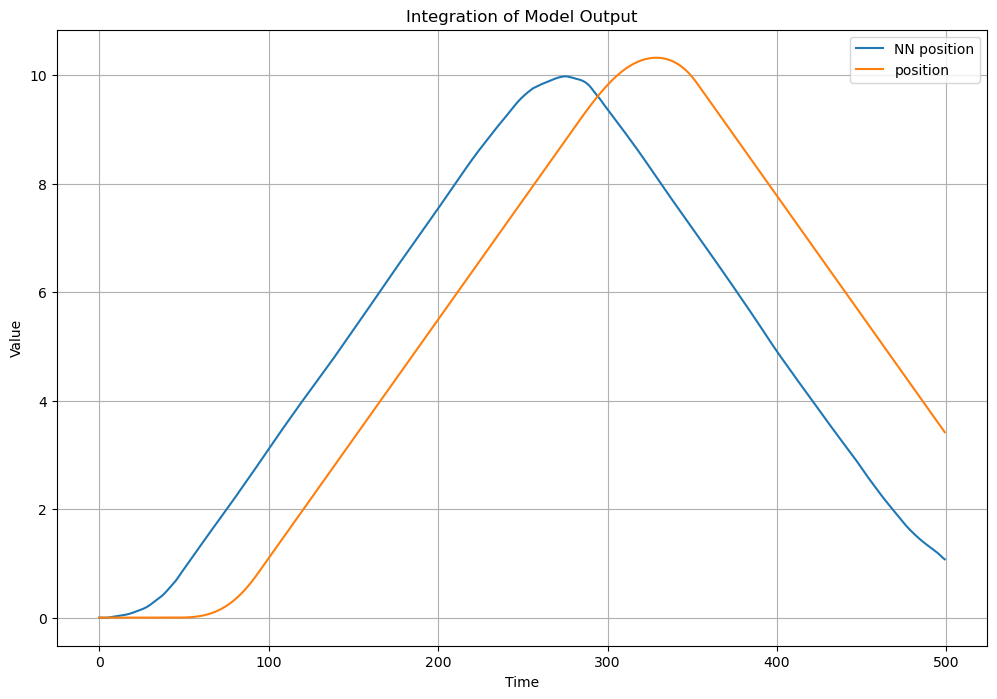

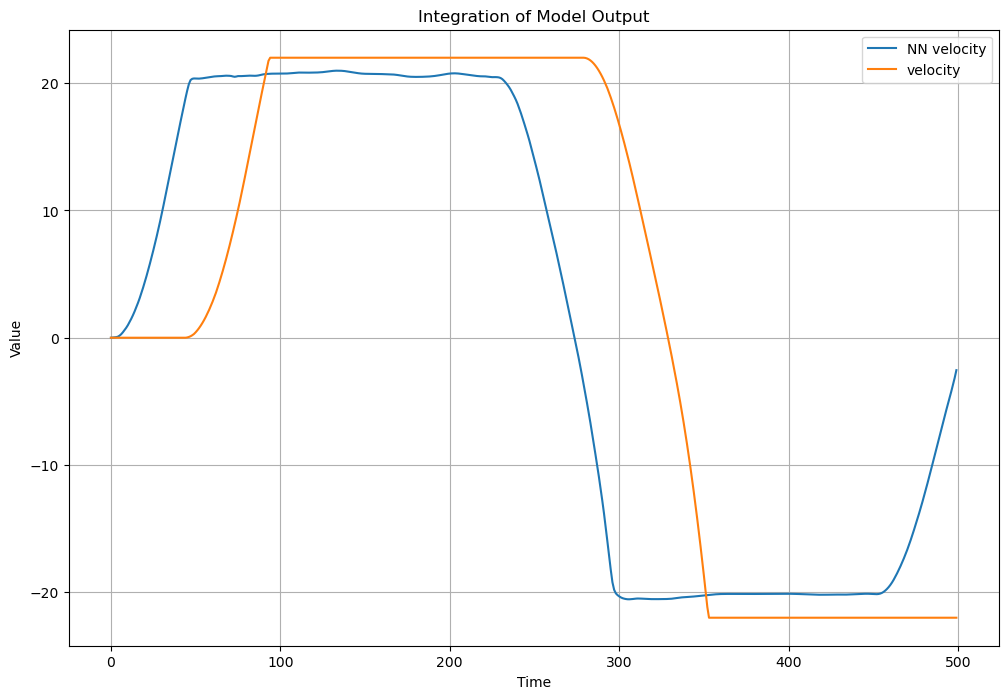

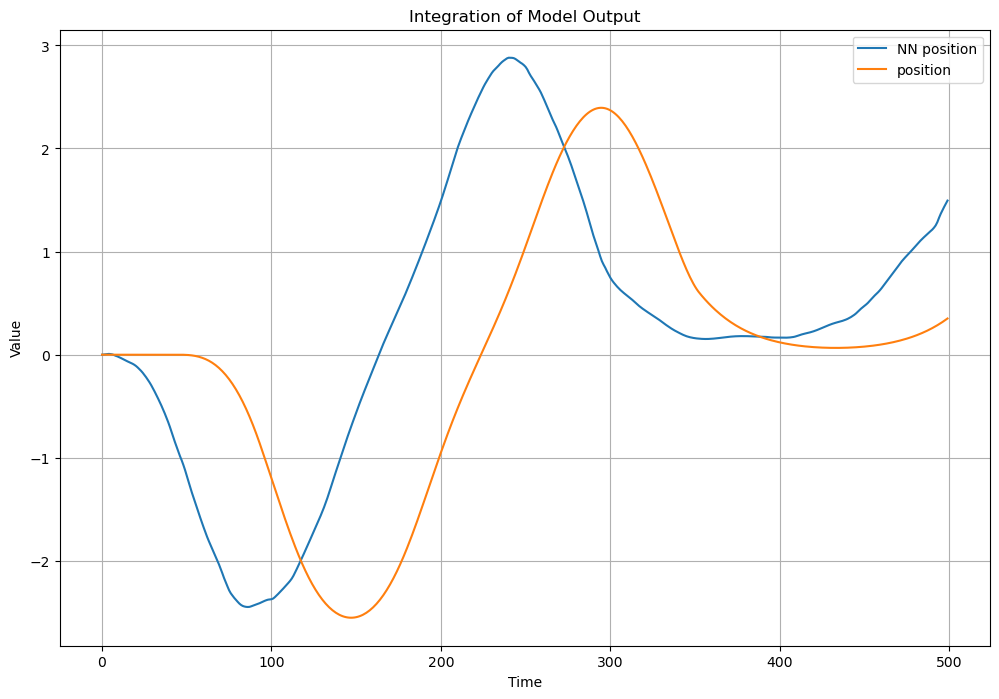

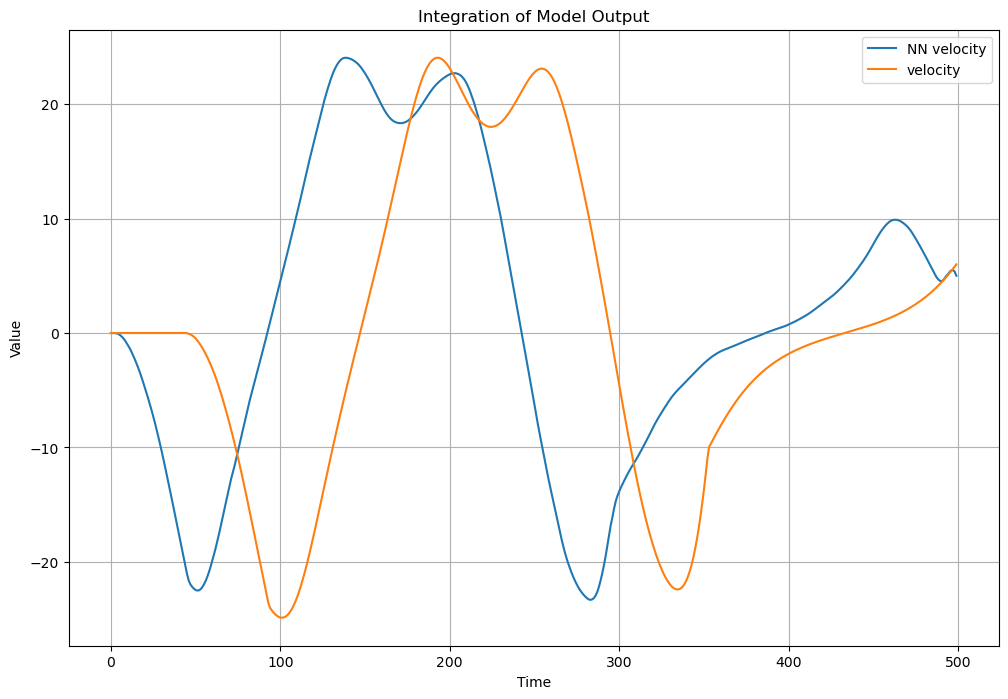

In [97]:
# Plot the results
for i in range(len(out[0])):
    plt.figure(figsize=(12, 8))

    offset = 0
    plt.plot(
        range(offset, len(out) + offset),
        out[:, i].cpu().detach().numpy(),
        label="NN " + x_columns[i].split("/")[-1],
    )
    plt.plot(
        range(0, len(out)),
        [all_x_values[j][i] for j in range(len(out))],
        label=x_columns[i].split("/")[-1],
    )

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title("Integration of Model Output")
    plt.legend()
    plt.grid(True)
    plt.show()